In [1]:
import DataFunctions
import numpy as np

Overall idea of simulation: Do pairings taking into consideration current score (win-lose rate) and their geographical location. It will use an adaptation of the Swiss Pairing System, the main difference is that instead of participants having a ELO score or rating and being paired by it; we consider an objective function on the total distance travelled and find proper pairings that minimize it. This problem can be solved using networkx and the concept of a minimum weight matching.

Rules per each round:
1. Split teams by their current score (#wins)
2. Pair in groups from the highest scoring group to lowest scoring group.
3. Per each group, find the group of pairs that minimize the objective function.
4. If there are odd # of teams, demote unpaired team into next scoring group. If it has been demoted before, use the next possible pairing that includes that team.
5. If there exist unpaired teams, demote them into the next scoring group. 
6. After making all possible pairings, set distance of teams that are playing together to inf.
7. For each pairing, if both teams have the same # of home games, pick one to be home and one to be away randomly. If one team has more # home games than the other, pick the team with the least # home games to be home, the other to be the away.

Things to store in db:
1. Each team 2022 stats.
2. Each team # (from 0 to 131).
3. Simulated season pairings, w-l record and h-a count.
4. Simulated games and scores.

Simulating each pairing:
1. Use 2022 stats to predict a spread and totalpts. We use those as means.
2. Using a normal distribution on the spread and totalpts with the standard deviation found on the model. We randomly generate a result with the simulated spread and totalpts.
3. We use obtained values to create an score.

In [2]:
#creating random distance matrix of size = 8
nteams = 8

m_dist = np.around(np.random.uniform(1,10,size=(nteams,nteams)),decimals=3)

for i in range(nteams):
    for j in range(nteams):
        m_dist[j,i]=m_dist[i,j]
    m_dist[i,i]=0

m_dist

array([[0.   , 2.163, 8.214, 3.776, 1.71 , 1.395, 7.126, 5.257],
       [2.163, 0.   , 2.544, 6.078, 9.815, 9.719, 9.991, 2.937],
       [8.214, 2.544, 0.   , 8.572, 8.502, 5.057, 3.279, 6.891],
       [3.776, 6.078, 8.572, 0.   , 3.918, 5.491, 2.617, 1.382],
       [1.71 , 9.815, 8.502, 3.918, 0.   , 9.648, 7.286, 4.706],
       [1.395, 9.719, 5.057, 5.491, 9.648, 0.   , 1.127, 9.455],
       [7.126, 9.991, 3.279, 2.617, 7.286, 1.127, 0.   , 5.557],
       [5.257, 2.937, 6.891, 1.382, 4.706, 9.455, 5.557, 0.   ]])

In [3]:
#storing wins per team.
curr_data = np.zeros(shape=(nteams,3),dtype=int)
curr_data[:,0] = np.arange(nteams)
curr_data

array([[0, 0, 0],
       [1, 0, 0],
       [2, 0, 0],
       [3, 0, 0],
       [4, 0, 0],
       [5, 0, 0],
       [6, 0, 0],
       [7, 0, 0]])

In [4]:
#splitting in groups (need function here)
sim1group0 = [x[0].astype(int) for x in curr_data if x[1]==0]
# sim1group1 = [[x[0].astype(int),0] for x in curr_data if x[1]==1]
sim1group0

[0, 1, 2, 3, 4, 5, 6, 7]

We cannot find all pairs and run for all of them. That operation has time complexity O(n!) and for 130ish teams is not feasible as it is about $10^{220}$. We need to use another approach.<br>
Algorithm procedure using networkx and Blossom algorithm (also known as Edmonds' algorithm) for the minimum weight matching.

In [5]:
import networkx as nx

In [6]:
L = []
G = nx.Graph()

for i in sim1group0:
    for j in sim1group0:
        if i<j: 
            L.append((i,j,m_dist[i,j]))

In [7]:
G.add_weighted_edges_from(L)

In [8]:
G.edges.data("weight")

EdgeDataView([(0, 1, 2.163), (0, 2, 8.214), (0, 3, 3.776), (0, 4, 1.71), (0, 5, 1.395), (0, 6, 7.126), (0, 7, 5.257), (1, 2, 2.544), (1, 3, 6.078), (1, 4, 9.815), (1, 5, 9.719), (1, 6, 9.991), (1, 7, 2.937), (2, 3, 8.572), (2, 4, 8.502), (2, 5, 5.057), (2, 6, 3.279), (2, 7, 6.891), (3, 4, 3.918), (3, 5, 5.491), (3, 6, 2.617), (3, 7, 1.382), (4, 5, 9.648), (4, 6, 7.286), (4, 7, 4.706), (5, 6, 1.127), (5, 7, 9.455), (6, 7, 5.557)])

In [9]:
matchings1g0 = nx.algorithms.matching.min_weight_matching(G)

In [10]:
LM = list(matchings1g0)
LM

[(3, 7), (1, 2), (0, 4), (6, 5)]

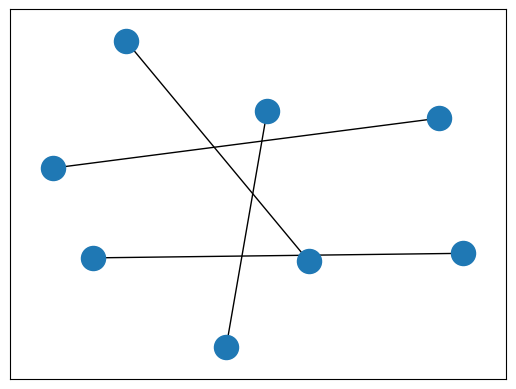

In [11]:
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G,pos)
nx.draw_networkx_edges(G,pos,edgelist=list(matchings1g0))

In [12]:
#checking 
m_dist[1,7],m_dist[5,0],m_dist[4,2],m_dist[3,6]

(2.937, 1.395, 8.502, 2.617)

In [13]:
LS = sorted(np.array(L)[:,2])
print(LS)

[1.127, 1.382, 1.395, 1.71, 2.163, 2.544, 2.617, 2.937, 3.279, 3.776, 3.918, 4.706, 5.057, 5.257, 5.491, 5.557, 6.078, 6.891, 7.126, 7.286, 8.214, 8.502, 8.572, 9.455, 9.648, 9.719, 9.815, 9.991]


In [14]:
s = set(sim1group0)-set(np.array(list(matchings1g0)).flatten()) 
# to find which one goes to the next group in odd cases 
# or those unpairable teams (team has played every other team)
if s!=set(): print("True")
else: print("False")

False


In [15]:
#merging all pairings
pairingssim1 = []
pairingssim1 +=matchings1g0
pairingssim1

#simulating matches
for g in pairingssim1:
    #home and away status
    if curr_data[g[0],2] == curr_data[g[1],2]:
        curr_data[g[np.random.randint(2)],2]+=1
    elif curr_data[g[0],2] > curr_data[g[1],2]:
        curr_data[g[1],2]+=1
    else:
        curr_data[g[0],2]+=1
    
    #simulating match
    if(np.random.randint(2)):
        curr_data[g[0],1] += 1
        print(g[0],"won")
        print(g[1],"lose")
    else:
        curr_data[g[1],1] += 1
        print(g[1],"won")
        print(g[0],"lose")
    # m_dist[g[0],g[1]]=0
    # m_dist[g[1],g[0]]=0
    G.remove_edge(u=g[0],v=g[1])

3 won
7 lose
1 won
2 lose
0 won
4 lose
5 won
6 lose


In [16]:
curr_data

array([[0, 1, 1],
       [1, 1, 1],
       [2, 0, 0],
       [3, 1, 0],
       [4, 0, 0],
       [5, 1, 1],
       [6, 0, 0],
       [7, 0, 1]])

In [17]:
#week 2
sim2 = [np.array([x[0].astype(int) for x in curr_data if x[1]==1]),
        np.array([x[0].astype(int) for x in curr_data if x[1]==0])]
sim2

[array([0, 1, 3, 5]), array([2, 4, 6, 7])]

In [18]:
Gs2g1 = G.subgraph(sim2[1])
Gs2g0 = G.subgraph(sim2[0])

In [19]:
matchings2g1 = nx.algorithms.matching.min_weight_matching(Gs2g1)
matchings2g0 = nx.algorithms.matching.min_weight_matching(Gs2g0)

In [20]:
list(matchings2g1),list(matchings2g0)

([(6, 2), (4, 7)], [(1, 3), (5, 0)])

In [21]:
#merging all pairings
pairingssim2 = []
pairingssim2 += matchings2g1
pairingssim2 += matchings2g0

#simulating matches
for g in pairingssim2:
    #home and away status
    if curr_data[g[0],2] == curr_data[g[1],2]:
        curr_data[g[np.random.randint(2)],2]+=1
    elif curr_data[g[0],2] > curr_data[g[1],2]:
        curr_data[g[1],2]+=1
    else:
        curr_data[g[0],2]+=1
    
    #simulating match
    if(np.random.randint(2)):
        curr_data[g[0],1] += 1
        print(g[0],"won")
        print(g[1],"lose")
    else:
        curr_data[g[1],1] += 1
        print(g[1],"won")
        print(g[0],"lose")
    # m_dist[g[0],g[1]]=0
    # m_dist[g[1],g[0]]=0
    G.remove_edge(u=g[0],v=g[1])

6 won
2 lose
4 won
7 lose
1 won
3 lose
5 won
0 lose


In [22]:
curr_data

array([[0, 1, 2],
       [1, 2, 1],
       [2, 0, 1],
       [3, 1, 1],
       [4, 1, 1],
       [5, 2, 1],
       [6, 1, 0],
       [7, 0, 1]])

In [23]:
#week 3
sim3 = [np.array([x[0].astype(int) for x in curr_data if x[1]==2]),
        np.array([x[0].astype(int) for x in curr_data if x[1]==1]),
        np.array([x[0].astype(int) for x in curr_data if x[1]==0])]
sim3

[array([1, 5]), array([0, 3, 4, 6]), array([2, 7])]

In [24]:
Gs3g2 = G.subgraph(sim3[2])
Gs3g1 = G.subgraph(sim3[1])
Gs3g0 = G.subgraph(sim3[0])

In [25]:
matchings3g2 = nx.algorithms.matching.min_weight_matching(Gs3g2)
matchings3g1 = nx.algorithms.matching.min_weight_matching(Gs3g1)
matchings3g0 = nx.algorithms.matching.min_weight_matching(Gs3g0)

In [26]:
#merging all pairings
pairingssim3 = []
pairingssim3 += matchings3g2
pairingssim3 += matchings3g1
pairingssim3 += matchings3g0

#simulating matches
for g in pairingssim3:
    #home and away status
    if curr_data[g[0],2] == curr_data[g[1],2]:
        curr_data[g[np.random.randint(2)],2]+=1
    elif curr_data[g[0],2] > curr_data[g[1],2]:
        curr_data[g[1],2]+=1
    else:
        curr_data[g[0],2]+=1
    
    #simulating match
    if(np.random.randint(2)):
        curr_data[g[0],1] += 1
        print(g[0],"won")
        print(g[1],"lose")
    else:
        curr_data[g[1],1] += 1
        print(g[1],"won")
        print(g[0],"lose")
    # m_dist[g[0],g[1]]=0
    # m_dist[g[1],g[0]]=0
    G.remove_edge(u=g[0],v=g[1])

2 won
7 lose
4 won
3 lose
0 won
6 lose
1 won
5 lose


In [27]:
curr_data

array([[0, 2, 2],
       [1, 3, 1],
       [2, 1, 2],
       [3, 1, 1],
       [4, 2, 2],
       [5, 2, 2],
       [6, 1, 1],
       [7, 0, 1]])

In [28]:
# now here we need the use of functions to be able to add TEAM 1 to group 2 and TEAM 5 to group 1 as they cannot be paired by themselves.
# for the first group, if there are issues then demote them, for the last group they have to ascend as the groups in the middle are larger.

In [29]:
# pending: make everything to functions.
# pending: Think on how to store games and their outcomes
# either database or simulated games on db and team record or game id.

In [33]:
nteams = 32
m_dist = np.around(np.random.uniform(1,10,size=(nteams,nteams)),decimals=3)

for i in range(nteams):
    for j in range(nteams):
        m_dist[j,i]=m_dist[i,j]
        if i<j: L.append((i,j,m_dist[i,j]))
    m_dist[i,i]=0

CollegeGraph = nx.Graph()
CollegeGraph.add_weighted_edges_from(L)
curr_data = np.zeros(shape=(nteams,3),dtype=int)
curr_data[:,0] = np.arange(nteams)

for i in range(5):
    DataFunctions.Simulate(g=CollegeGraph,i=i,c=curr_data)

Round: 1
9 won 23 lose
6 lose 31 won
16 won 26 lose
7 won 20 lose
5 lose 14 won
12 won 19 lose
1 won 4 lose
30 lose 0 won
3 won 13 lose
29 lose 22 won
11 lose 15 won
10 won 25 lose
18 won 21 lose
17 lose 24 won
27 lose 28 won
2 lose 8 won
Round: 2
0 won 16 lose
10 won 1 lose
18 won 28 lose
9 lose 14 won
15 lose 3 won
24 won 31 lose
7 won 8 lose
22 lose 12 won
4 won 23 lose
2 won 26 lose
27 won 20 lose
17 lose 29 won
5 won 6 lose
25 won 30 lose
19 won 21 lose
13 lose 11 won
Round: 3
7 won 12 lose
18 won 24 lose
3 won 10 lose
14 lose 0 won
17 won 23 lose
13 won 26 lose
6 won 30 lose
20 lose 21 won
1 lose 15 won
5 won 27 lose
22 lose 4 won
8 lose 16 won
29 lose 19 won
11 won 28 lose
2 lose 9 won
31 lose 25 won
Round: 4
7 lose 0 won
18 won 3 lose
23 won 30 lose
20 lose 26 won
4 won 10 lose
24 won 16 lose
11 won 25 lose
14 won 19 lose
5 lose 9 won
15 lose 12 won
29 won 1 lose
31 won 27 lose
22 won 17 lose
8 lose 6 won
28 won 21 lose
13 lose 2 won
Round: 5
18 won 0 lose
30 lose 20 won
7 lose

In [34]:
curr_data

array([[ 0,  4,  2],
       [ 1,  1,  2],
       [ 2,  3,  3],
       [ 3,  3,  2],
       [ 4,  4,  3],
       [ 5,  3,  3],
       [ 6,  2,  2],
       [ 7,  3,  2],
       [ 8,  2,  3],
       [ 9,  4,  2],
       [10,  2,  3],
       [11,  3,  3],
       [12,  4,  3],
       [13,  1,  3],
       [14,  4,  2],
       [15,  3,  2],
       [16,  3,  3],
       [17,  1,  3],
       [18,  5,  2],
       [19,  2,  2],
       [20,  1,  3],
       [21,  2,  2],
       [22,  2,  3],
       [23,  2,  2],
       [24,  3,  2],
       [25,  2,  2],
       [26,  1,  2],
       [27,  2,  3],
       [28,  3,  3],
       [29,  3,  2],
       [30,  0,  3],
       [31,  2,  3]])